# Model Exploration - Fully Connected Dense Network

In [1]:
### Package Setups
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
from tensorflow import keras
import time

from helperFunctions import *


from tensorflow.keras.callbacks import Callback

import pandas as pd

import wandb
from wandb.keras import WandbCallback

#print all cell contents 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



1 Physical GPUs, 1 Logical GPUs


* For training 
    + Use 50 files ~ 200K samples
    + The shuffle buffer will be filled with these 200K samples (Memory utilisation 25GB)
* For Validation 
    + 5 files = 15K samples (~6%)



In [9]:
## Data Configuation
TRAIN_FILES_FOLDER = '../data/Train'
VAL_FILES_FOLDER = '../data/Validation'
TEST_FILES_FOLDER = '../data/Test'

TRAIN_STEPS_PER_EPOCH_MULTIPLIER = 2
VAL_STEPS_PER_EPOCH_MULTIPLIER = 2

data_config = dict(INPUT_SHAPE = (128,128,3)

                    ,TRAIN_FILES = 50
                    ,TRAIN_BATCH_SIZE = 512

                    ,VAL_FILES = 5
                    ,VAL_BATCH_SIZE = 512

                    ,PREFETCH = 5
)


data_config.update(TRAIN_SHUFFLE_BUFFER_SIZE = samplesCount(data_config['TRAIN_FILES'],TRAIN_FILES_FOLDER))
data_config.update(TRAIN_STEPS_PER_EPOCH = round(data_config['TRAIN_SHUFFLE_BUFFER_SIZE']/data_config['TRAIN_BATCH_SIZE'])*TRAIN_STEPS_PER_EPOCH_MULTIPLIER)

data_config.update(VAL_SHUFFLE_BUFFER_SIZE = samplesCount(data_config['VAL_FILES'],VAL_FILES_FOLDER))
data_config.update(VAL_STEPS_PER_EPOCH = round(data_config['VAL_SHUFFLE_BUFFER_SIZE']/data_config['VAL_BATCH_SIZE'])*VAL_STEPS_PER_EPOCH_MULTIPLIER)
     
# samplesCount(data_config['TRAIN_FILES'],TRAIN_FILES_FOLDER)
# samplesCount(data_config['VAL_FILES'],VAL_FILES_FOLDER)


### Model Configuration
model_config = dict(
      EXPERIMENT = 'FC Baseline'
      ,METRICS = [ keras.metrics.Precision(name='precision'),keras.metrics.Recall(name='recall'),keras.metrics.AUC(name='auc')]
      ,LR = 1e-4
      ,EPOCHS = 100
      ,VAL_FREQUENCY = 1
)

### Data Loading
train = createIODataset(data_config['TRAIN_FILES'],TRAIN_FILES_FOLDER)
val = createIODataset(data_config['VAL_FILES'],VAL_FILES_FOLDER)

train = train.shuffle(buffer_size=data_config['TRAIN_SHUFFLE_BUFFER_SIZE'],reshuffle_each_iteration=True)
train = train.repeat(-1)
train = train.batch(data_config['TRAIN_BATCH_SIZE'],drop_remainder=True)
train = train.prefetch(data_config['PREFETCH'])

val = val.shuffle(buffer_size=data_config['VAL_SHUFFLE_BUFFER_SIZE'],reshuffle_each_iteration=True)
val = val.repeat(-1)
val = val.batch(data_config['VAL_BATCH_SIZE'],drop_remainder=True)
val = val.prefetch(data_config['PREFETCH'])




## Network Architecture

In [5]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=data_config['INPUT_SHAPE']))
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255))

# model.add(tf.keras.layers.Dense(32,activation='relu',kernel_initializer='glorot_normal'))
# model.add(tf.keras.layers.Dropout(DROPOUT))

for units in [32,16,8]:
    model.add(tf.keras.layers.Dense(units,activation='relu',kernel_initializer='he_normal'))

model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 49152)             0         
_________________________________________________________________
rescaling (Rescaling)        (None, 49152)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                1572896   
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 1,573,569
Trainable params: 1,573,569
Non-trainable params: 0
______________________________________________

In [ ]:
run = wandb.init(project="candlestick-CNN", name = model_config['EXPERIMENT'] ,reinit= True,dir = '../data/'
                    ,config = {**data_config,**model_config})

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=model_config['LR'])
                        ,loss=tf.keras.losses.binary_crossentropy
                        ,metrics=model_config['METRICS'])

history = model.fit(train
                ,epochs=model_config['EPOCHS']
                ,steps_per_epoch=data_config['TRAIN_STEPS_PER_EPOCH']
                ,verbose=1
                ,validation_data=val                
                ,validation_freq = model_config['VAL_FREQUENCY']
                ,validation_steps = data_config['VAL_STEPS_PER_EPOCH']
                ,callbacks=[WandbCallback()]
                )
  
run.finish()

# model.save('../data/saved_models/' + model_config['EXPERIMENT'] )


Text(0.5, 0, 'epoch')

Text(0, 0.5, 'loss')

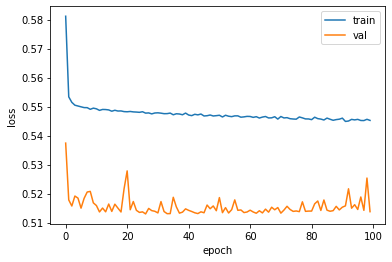

In [11]:
import matplotlib.pyplot as plt
df = pd.DataFrame(history.history)
plt.plot(df['loss'])
plt.plot(df['val_loss'])

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc='upper right')

## Observations
* The model is taking long time to converge as the dataset is large. Options :
    + Train longer
    + Use Cyclical learning rate
    + Use transfer learning for better initialisation
* The validation loss is less then train     

## Test Set Evaluation

The Actual value for image 6 is 1 and predicted value of  0  with a confidence percentage of  0.5751417


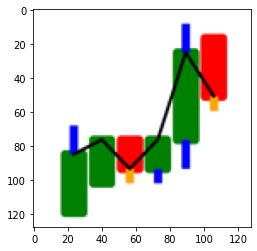

In [7]:
import h5py

fname = "../data/Test/SetA2M.AX.h5"
file = h5py.File(fname, "r")
set_x = file["set_x"][:]
set_y = file["set_y"][:]

IMG_INDEX = 6

plt.imshow(set_x[IMG_INDEX].astype('uint8'))

score = tf.nn.sigmoid(model.predict(tf.expand_dims(set_x[IMG_INDEX], 0),batch_size=1))

print("The Actual value for image", IMG_INDEX, "is", set_y[IMG_INDEX],"and predicted value of ", np.argmax(score), " with a confidence percentage of " , np.max(score))
